# Prediction - it's rain or not?

## Imports

In [1]:
!pip install kneed
!pip install dtaidistance
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=471391 sha256=febd5465b9278d60246d7041df2ff9605596a0a51fca562a3385cbabf0e4e8da
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [2]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Switch to the directory on the Google Drive that you want to use
  import os

  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  drive.mount(mount)
  drive_root = mount + "/My Drive/pluie/"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/pluie/  exists.

Colab: Changing directory to  /content/gdrive/My Drive/pluie/
/content/gdrive/My Drive/pluie


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

from aing import *
from cfica import *
from clustering import *

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


# Only one file

## Data Loading

In [4]:
# Replace Pluie by the exact file name Exo_Crews...
data=pd.read_csv("Douala/CML_Douala/L1_172.22.204.1P4.1-172.22.204.6P4.1_29A-B.csv",sep=";", parse_dates=['datetime'])

# verify your number of observations and columns
# change separator if needed ',' or '\t' ...
print(data.shape[0], "observations (lines) by ", data.shape[1], "features (columns)")



39456 observations (lines) by  17 features (columns)


## Data exploration

In [5]:
data.head(5)


,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
0,2018-06-06 00:05:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
1,2018-06-06 00:20:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
2,2018-06-06 00:35:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
3,2018-06-06 00:50:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
4,2018-06-06 01:05:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022


In [6]:
data.tail(5)

,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
39451,2019-12-31 22:52:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39452,2019-12-31 23:07:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39453,2019-12-31 23:22:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39454,2019-12-31 23:37:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39455,2019-12-31 23:52:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,4.0,4.0,4.0,-43.0,-43.0,-43.0,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022


In [7]:
# detection of Meta-Data
# a Meta-data could be a unique value, or reduced number (Quality code)
metaValue = 1
card = []
for i in range(data.shape[1]):
    card.append(len(data.iloc[:, i].unique()))

# extraction of non Meta information
subset = np.array(card) > metaValue
df = data.loc[:, subset]

print(df.head(n=3))
print("...")
print(df.tail(n=2))


             datetime  TSL_min  TSL_mean  TSL_max  RSL_min  RSL_mean  RSL_max  \
0 2018-06-06 00:05:00      NaN       NaN      NaN      NaN       NaN      NaN   
1 2018-06-06 00:20:00      NaN       NaN      NaN      NaN       NaN      NaN   
2 2018-06-06 00:35:00      NaN       NaN      NaN      NaN       NaN      NaN   

   Rgage  
0    NaN  
1    NaN  
2    NaN  
...
                 datetime  TSL_min  TSL_mean  TSL_max  RSL_min  RSL_mean  \
39454 2019-12-31 23:37:00      NaN       NaN      NaN      NaN       NaN   
39455 2019-12-31 23:52:00      4.0       4.0      4.0    -43.0     -43.0   

       RSL_max  Rgage  
39454      NaN    NaN  
39455    -43.0    NaN  


In [8]:
# date identification
df.loc[:, 'datetime']=pd.to_datetime(df.loc[:,"datetime"], format="%Y-%m-%d %H:%M:%S")
df.set_index("datetime", inplace=True)
df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

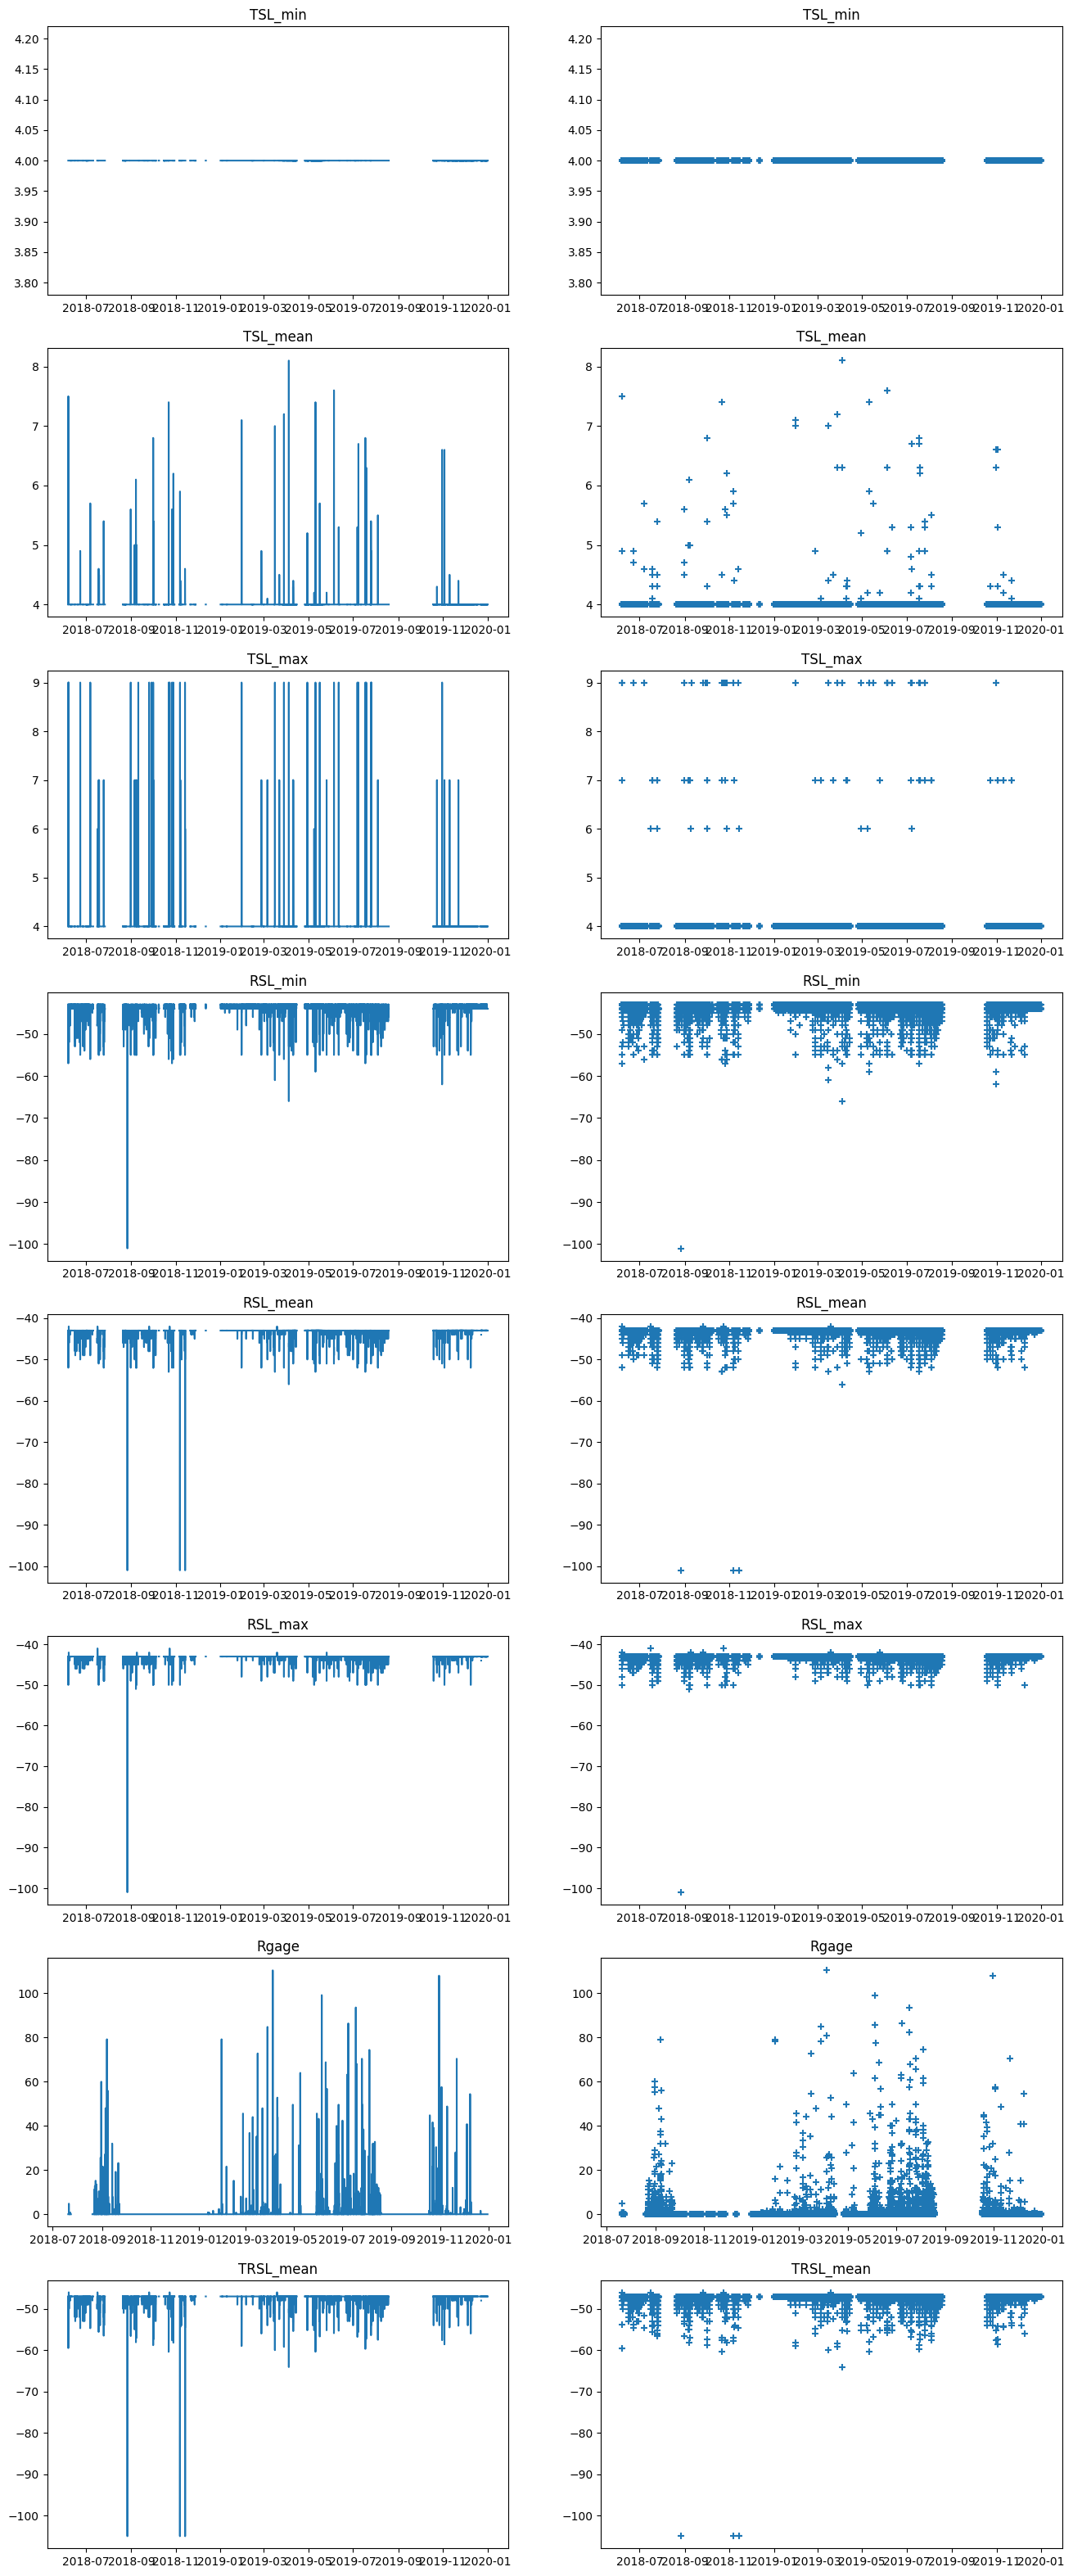

In [9]:
fig, axs = plt.subplots(len(df.columns), 2, figsize=(16, 5 * len(df.columns)))

for i, col in enumerate(df.columns):
    axs[i, 0].plot(df[col])
    axs[i, 0].set_title(col)
    axs[i, 1].scatter(df.index, df[col], marker='+')
    axs[i, 1].set_title(col)

plt.show()


## Identification of Pattern by unsupervised approach

In [10]:
#remove observations with NA information
df.dropna(inplace=True)
df.describe()


,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,TRSL_mean
count,34302.0,34302.000000,34302.000000,34302.000000,34302.000000,34302.000000,34302.000000,34302.000000
mean,4.0,4.003326,4.010991,-43.744038,-43.143869,-43.105562,0.373879,-47.147195
std,0.0,0.085244,0.214681,1.179975,0.903737,0.567703,3.383362,0.934710
min,4.0,4.000000,4.000000,-101.000000,-101.000000,-101.000000,0.000000,-105.000000
25%,4.0,4.000000,4.000000,-44.000000,-43.000000,-43.000000,0.000000,-47.000000
50%,4.0,4.000000,4.000000,-44.000000,-43.000000,-43.000000,0.000000,-47.000000
75%,4.0,4.000000,4.000000,-43.000000,-43.000000,-43.000000,0.000000,-47.000000
max,4.0,8.100000,9.000000,-43.000000,-42.000000,-41.000000,110.400000,-46.000000


In [11]:

# Normalisation

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.index = df.index
df_scaled.head()

,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,TRSL_mean
datetime,,,,,,,,
2018-07-20 12:35:00,0.0,-0.039022,-0.051196,-0.216925,0.159196,0.185949,-0.110507,0.157479
2018-07-20 12:50:00,0.0,-0.039022,-0.051196,0.630564,0.159196,0.185949,-0.110507,0.157479
2018-07-20 13:05:00,0.0,-0.039022,-0.051196,0.630564,0.159196,0.185949,-0.110507,0.157479
2018-07-20 13:20:00,0.0,-0.039022,-0.051196,-0.216925,0.159196,0.185949,-0.110507,0.157479
2018-07-20 13:35:00,0.0,-0.039022,-0.051196,-0.216925,0.159196,0.185949,-0.110507,0.157479


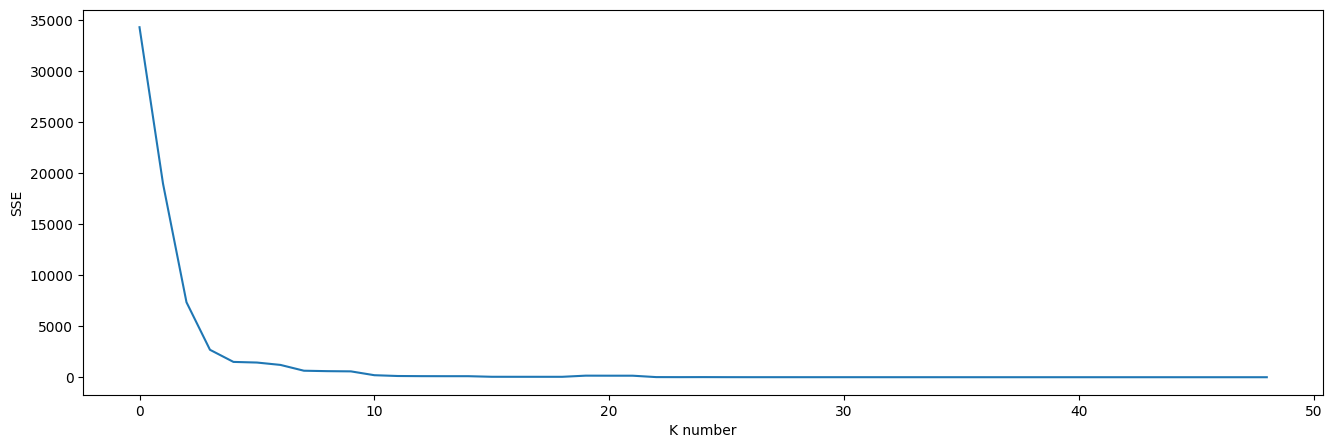

The optimal value of k is: 5


In [12]:
#File 1 identify pattern structure without temporal information
sse = []
Kmax = 50
for k in range(1, Kmax):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter=300, random_state = 42)
    kmeans.fit(df_scaled[['TRSL_mean']])
    sse.append(kmeans.inertia_)
plt.figure(figsize= (16,5))
plt.xlabel("K number")
plt.ylabel("SSE")
plt.plot(sse)
plt.show()
kl = KneeLocator(range(1, Kmax), sse, curve="convex", direction="decreasing")
print(f"The optimal value of k is: {kl.elbow}")


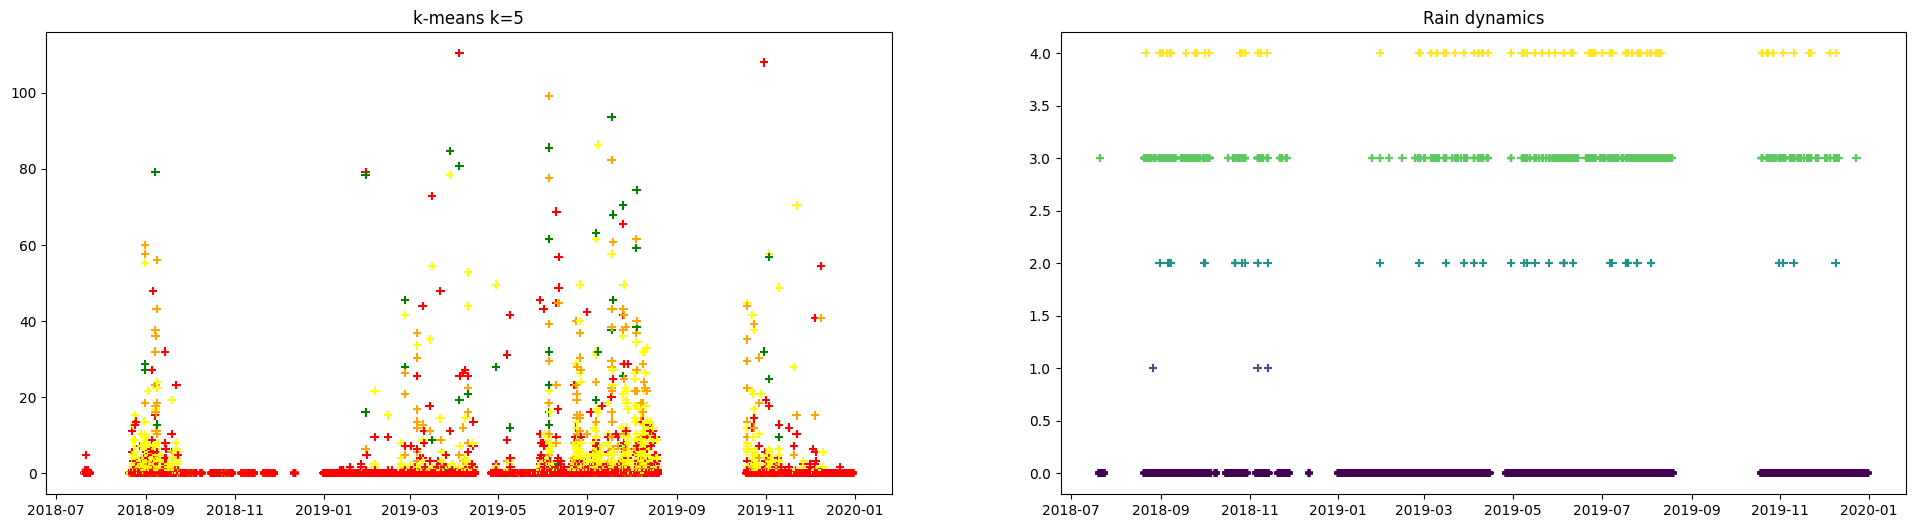

In [13]:
km1 = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300, random_state=42)
km1.fit(df_scaled.loc[:, ['TRSL_mean']])

fig, axs = plt.subplots(1, 2, figsize=(24, 6))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'cyan', 'magenta', 'grey']
axs[0].scatter(df_scaled.index, df['Rgage'], c=[colors[i] for i in km1.labels_], marker='+')
axs[0].set_title(f"k-means k={kl.elbow}", fontdict={"fontsize": 12})

axs[1].scatter(df_scaled.index, km1.labels_, c=km1.labels_, marker='+')
axs[1].set_title("Rain dynamics")

plt.show()


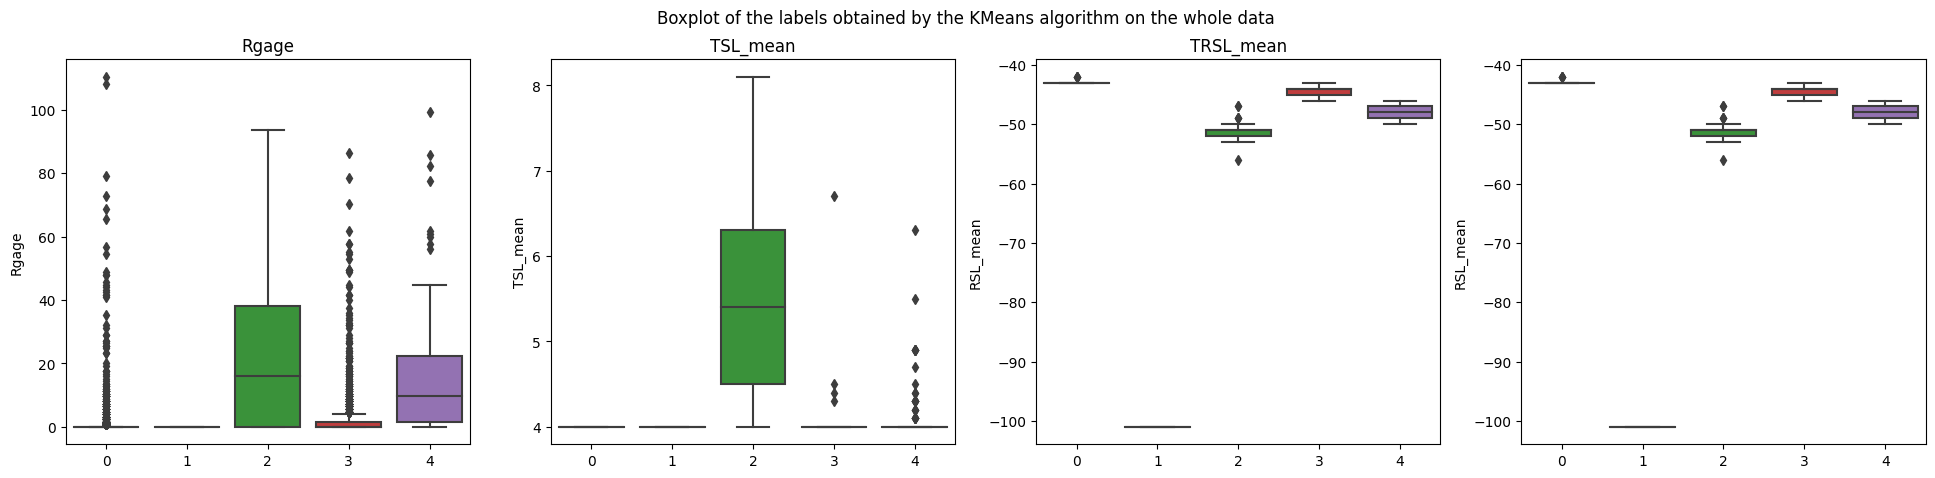

In [14]:
labels = km1.labels_

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

sns.boxplot(y=df.Rgage, x=labels, ax=axs[0])
axs[0].set_title("Rgage")

sns.boxplot(y=df.TSL_mean, x=labels, ax=axs[1])
axs[1].set_title("TSL_mean")

sns.boxplot(y=df.RSL_mean, x=labels, ax=axs[2])
axs[2].set_title("RSL_mean")

sns.boxplot(y=df.RSL_mean, x=labels, ax=axs[3])
axs[2].set_title("TRSL_mean")

plt.suptitle("Boxplot of the labels obtained by the KMeans algorithm on the whole data")
plt.show()


# Incremental Clustering

In [15]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = list(colors.keys())

def plot_data(df, y, labels, title):
    fig, axs = plt.subplots(1, 2, figsize=(24, 5))
    # plot the clusters and the centroids

    axs[0].scatter(df.index, y, c=[colors[i] for i in labels], marker='+')
    axs[0].set_xlabel("DateTime")
    axs[0].set_ylabel("Rain Gauge - RGage")
    axs[0].set_title(title)
    axs[1].scatter(df.index, labels, c=[colors[i] for i in labels], marker='+')
    axs[1].set_title("Labels")
    axs[1].set_xlabel("DateTime")
    axs[1].set_ylabel("labels")
    plt.show()


In [ ]:
#X=df_scaled.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
X = df_scaled.loc[:, ['TRSL_mean']]
y=df_scaled.Rgage



In [ ]:
cfica = CFICA(X.values, 200, 100, 1, 1.4)
cfica.fit()
labels2 = cfica.labels

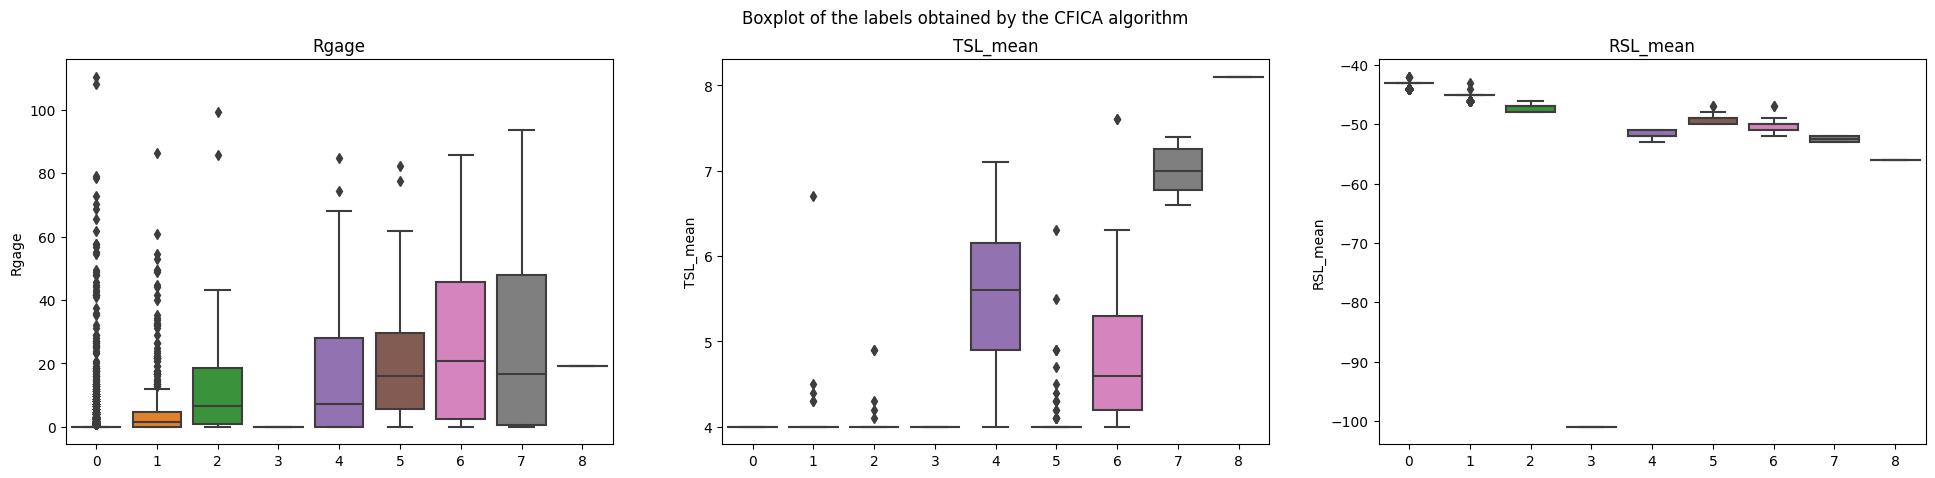

In [ ]:
labels_cfica = cfica.labels

fig, axs = plt.subplots(1, 3, figsize=(24, 5))

sns.boxplot(y=df.Rgage, x=labels_cfica, ax=axs[0])
axs[0].set_title("Rgage")

sns.boxplot(y=df.TSL_mean, x=labels_cfica, ax=axs[1])
axs[1].set_title("TSL_mean")

sns.boxplot(y=df.RSL_mean, x=labels_cfica, ax=axs[2])
axs[2].set_title("RSL_mean")

plt.suptitle("Boxplot of the labels obtained by the CFICA algorithm")
plt.show()


In [ ]:
clustering =  ProposedApproach(X.values, 200, 100, 0.1, 0.5)
clustering.fit()
clustering.cluster_outliers()
labels1 = clustering.labels

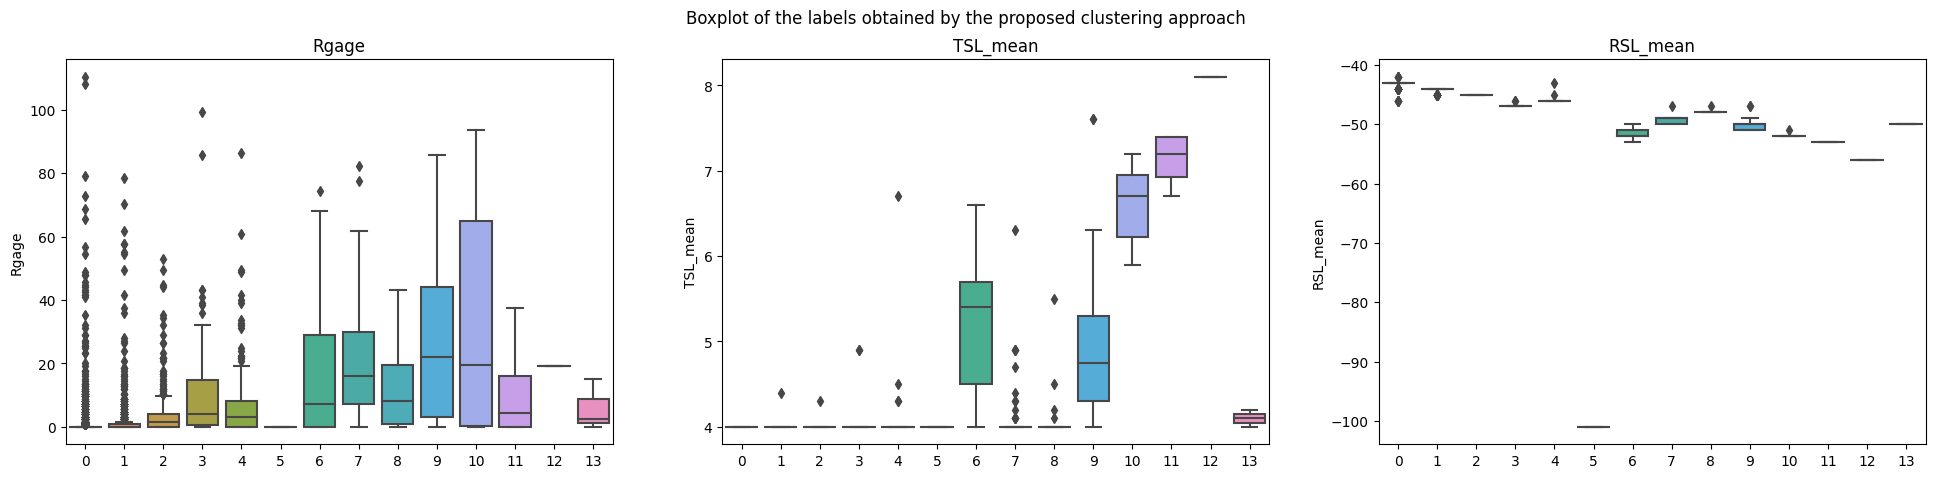

In [ ]:
labels_approach = clustering.labels

fig, axs = plt.subplots(1, 3, figsize=(24, 5))

sns.boxplot(y=df.Rgage, x=labels_approach, ax=axs[0])
axs[0].set_title("Rgage")

sns.boxplot(y=df.TSL_mean, x=labels_approach, ax=axs[1])
axs[1].set_title("TSL_mean")

sns.boxplot(y=df.RSL_mean, x=labels_approach, ax=axs[2])
axs[2].set_title("RSL_mean")

plt.suptitle("Boxplot of the labels obtained by the proposed clustering approach")
plt.show()


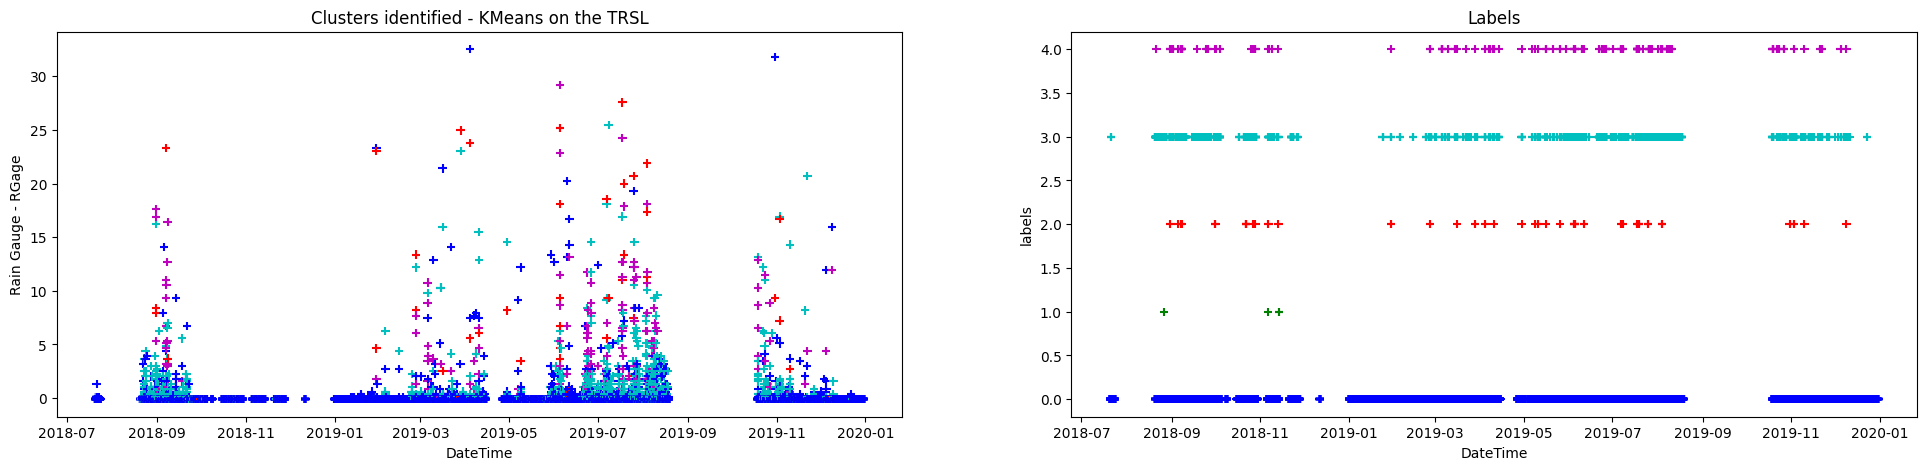

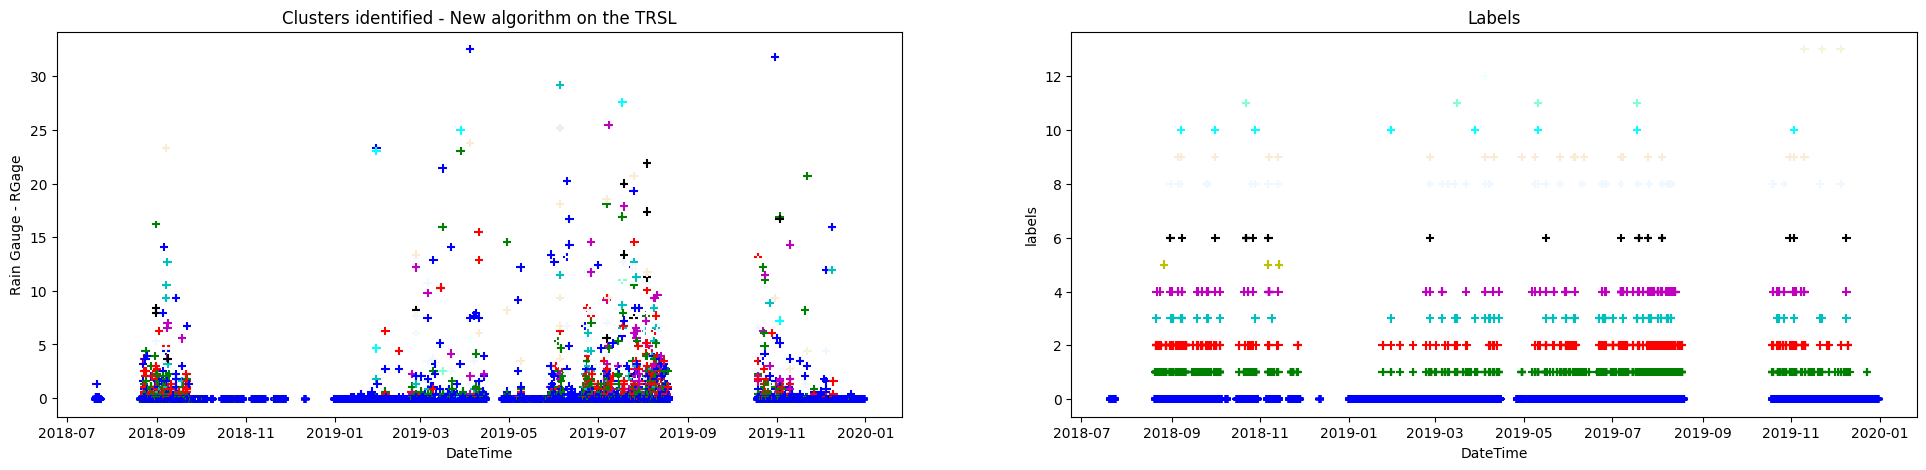

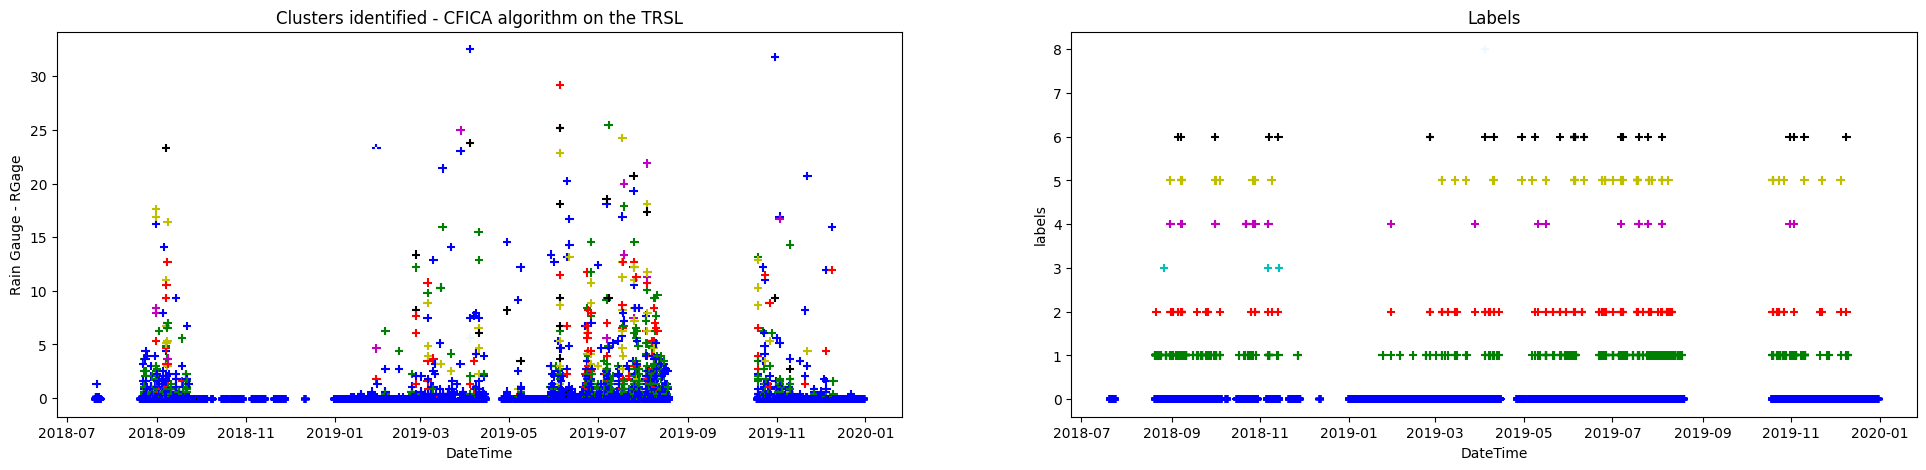

In [ ]:
plot_data(df, y, km1.labels_, "Clusters identified - KMeans on the TRSL")
plot_data(df, y, labels1, "Clusters identified - New algorithm on the TRSL")
plot_data(df, y, labels2, "Clusters identified - CFICA algorithm on the TRSL")
# plot_data(df, y, labels3, "Clusters identified - AING algorithm on the TRSL")



## Detection des évenements

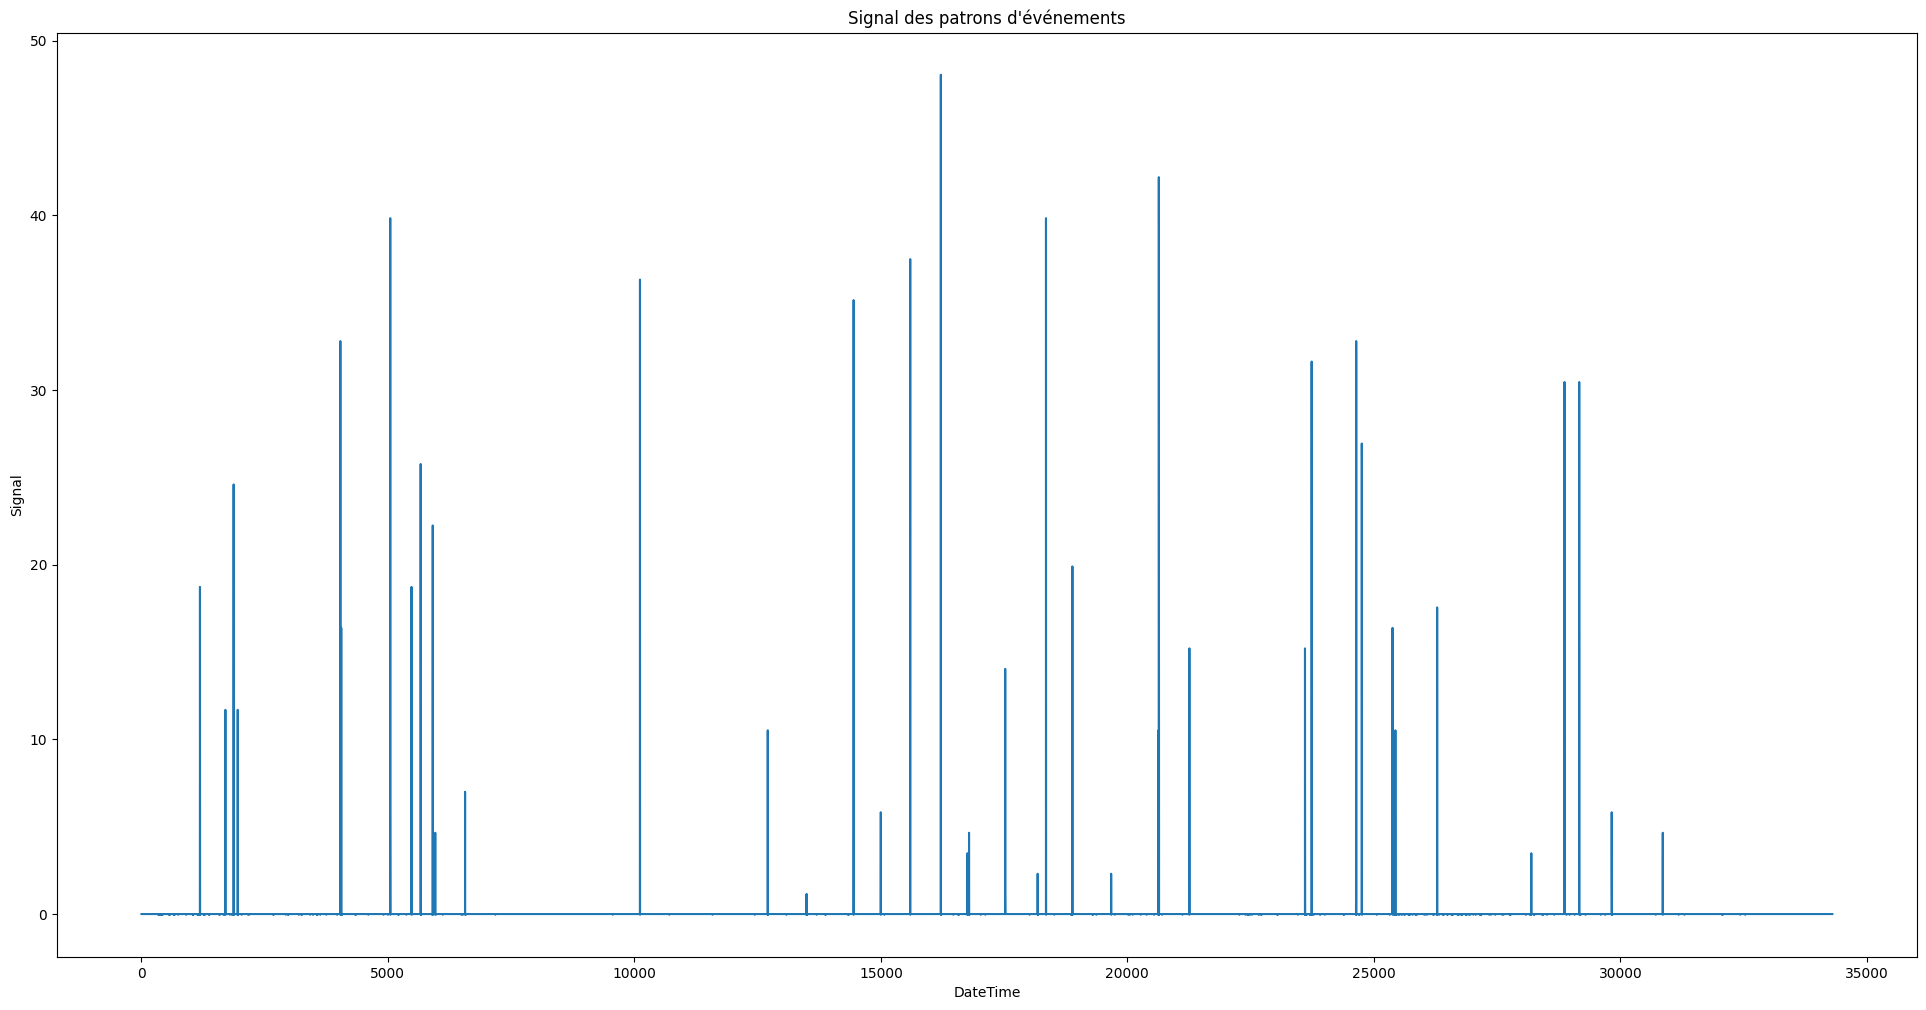

In [ ]:
# Détection des patrons d'évenements

plt.figure(figsize=(24, 12))
# Créer une liste pour stocker les données du signal
signal = []

# Parcourir les données des labels
for i in range(len(labels_cfica)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels_cfica[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean au signal
        signal.append(df_scaled['TSL_mean'].iloc[i])
    else:
        # Sinon, ajouter 0 au signal
        signal.append(0)

# Créer un graphique en utilisant les données du signal
plt.plot(signal)
plt.xlabel('DateTime')
plt.ylabel('Signal')
plt.title('Signal des patrons d\'événements')
plt.show()



In [ ]:
# Créer un nouveau DataFrame pour stocker les données des événements de pluie
rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

# Initialiser les variables pour stocker les données des événements de pluie
event = 0
amplitudes = []

# Parcourir les données des labels
for i in range(len(labels2)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels2[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean aux amplitudes de l'événement en cours
        amplitudes.append(df['TSL_mean'].iloc[i])
    else:
        # Si les amplitudes de l'événement en cours ne sont pas vides
        if len(amplitudes) > 0:
            # Vérifier si les labels suivants sont également 0
            next_labels_zero = True
            for j in range(i, min(i+10, len(labels2))):
                if labels2[j] != 0:
                    next_labels_zero = False
                    break
            # Si les labels suivants sont également 0
            if next_labels_zero:
                # Ajouter les données de l'événement en cours au DataFrame
                rain_events.loc[event] = [event, amplitudes]
                # Réinitialiser les variables pour le prochain événement
                event += 1
                amplitudes = []

# Afficher la table des événements de pluie
display(rain_events)



,Event,Amplitudes
0,0,[-0.03902185713147156]
1,1,"[-0.03902185713147156, -0.03902185713147156, -..."
2,2,"[-0.03902185713147156, -0.03902185713147156, -..."
3,3,"[-0.03902185713147156, -0.03902185713147156, -..."
4,4,"[-0.03902185713147156, -0.03902185713147156, -..."
...,...,...
178,178,"[-0.03902185713147156, -0.03902185713147156]"
179,179,"[-0.03902185713147156, -0.03902185713147156, -..."
180,180,[-0.03902185713147156]
181,181,"[-0.03902185713147156, -0.03902185713147156, -..."


In [ ]:
# Create a new DataFrame to store the data for the non-rain events
non_rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

# Initialize the variables to store the data for the non-rain events
event = 0
amplitudes = []

# Iterate over the data from the labels
for i in range(len(labels2)):
    # If the label is 0 (i.e., no rain)
    if labels2[i] == 0:
        # Add the corresponding amplitude from the TSL_mean column to the amplitudes of the current event
        amplitudes.append(df['TSL_mean'].iloc[i])
    else:
        # If the amplitudes of the current event are not empty and have a length of at least 10
        if len(amplitudes) > 10:
            # Add the data for the current event to the DataFrame;
            non_rain_events.loc[event] = [event, amplitudes]
            # Reset the variables for the next event
            event += 1
            amplitudes = []

display(non_rain_events)


,Event,Amplitudes
0,0,"[6.3, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ..."
1,1,"[8.7, 7.1, 6.6, 6.0, 6.0, 5.9, 6.0, 6.3, 6.0, ..."
2,2,"[7.7, 7.7, 7.4, 7.1, 7.0, 7.0, 7.0, 7.0, 7.0, ..."
3,3,"[8.3, 7.0, 7.6, 7.6, 7.5, 7.5, 7.9, 7.9, 7.8, ..."
4,4,"[8.0, 7.5, 7.5, 7.4, 7.0, 7.0, 7.0, 12.7, 7.7,..."
...,...,...
179,179,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
180,180,"[9.0, 8.7, 8.4, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
181,181,"[9.9, 9.5, 9.2, 9.0, 8.6, 8.5, 8.5, 8.5, 8.5, ..."
182,182,"[8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, ..."


In [ ]:
# Find the maximum length of the amplitudes
max_length = non_rain_events['Amplitudes'].str.len().max()

# Create a new DataFrame with separate columns for each amplitude
non_rain_events_sep = pd.DataFrame(columns=['Event'] + [f'a{i+1}' for i in range(max_length)])

# Iterate over the data from the non-rain events
for i, row in non_rain_events.iterrows():
    # Add the data for the event to the DataFrame
    non_rain_events_sep.loc[i, 'Event'] = row['Event']
    for j, amp in enumerate(row['Amplitudes']):
        non_rain_events_sep.loc[i, f'a{j+1}'] = amp

# Replace missing values with 0
non_rain_events_sep.fillna(0, inplace=True)

# Save the DataFrame to a CSV file
non_rain_events_sep.to_csv('non_rain_events_sep.csv', index=False)


# Détection des évenements pour 15 liens de pluie (TRAIN data)

In [ ]:
import os
import pandas as pd
from cfica import *

# Set the path to the data folder
data_folder = 'Douala/CML_Douala/'

# Create an empty list to store the rain events from each file
all_rain_events = []
all_non_rain_events = []
# Iterate over the files in the data folder
for filename in os.listdir(data_folder):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Read in the data from the CSV file
        data = pd.read_csv(os.path.join(data_folder, filename), sep=';', parse_dates=['datetime'])
        metaValue = 1
        card = []
        for i in range(data.shape[1]):
            card.append(len(data.iloc[:, i].unique()))

        # extraction of non Meta information
        subset = np.array(card) > metaValue
        df = data.loc[:, subset]

        # date identification
        df.loc[:, 'datetime']=pd.to_datetime(df.loc[:,"datetime"], format="%Y-%m-%d %H:%M:%S")
        df.set_index("datetime", inplace=True)
        df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

        #remove observations with NA information
        df.dropna(inplace=True)

        # Normalisation

        from sklearn.preprocessing import StandardScaler
        std_scaler = StandardScaler()
        df_scaled = std_scaler.fit_transform(df.to_numpy())
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)


        # Process the data to find the rain events (same as in your previous code)
        X=df_scaled.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
        y=df_scaled.Rgage

        clustering =  ProposedApproach(X.values, 1200, 100, 4, 1)
        clustering.fit()
        clustering.cluster_outliers()
        labels1 = clustering.labels

        # Créer un nouveau DataFrame pour stocker les données des événements de pluie
        rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

        # Initialiser les variables pour stocker les données des événements de pluie
        event = 0
        amplitudes = []

        # Parcourir les données des labels
        for i in range(len(labels1)):
            # Si le label change de 0 vers un autre label
            if i > 0 and labels1[i] != 0:
                # Ajouter l'amplitude correspondante dans la colonne TSL_mean aux amplitudes de l'événement en cours
                amplitudes.append(df['TSL_mean'].iloc[i])
            else:
                # Si les amplitudes de l'événement en cours ne sont pas vides
                if len(amplitudes) > 0:
                    # Vérifier si les labels suivants sont également 0
                    next_labels_zero = True
                    for j in range(i, min(i+10, len(labels1))):
                        if labels1[j] != 0:
                            next_labels_zero = False
                            break
                    # Si les labels suivants sont également 0
                    if next_labels_zero:
                        # Ajouter les données de l'événement en cours au DataFrame
                        rain_events.loc[event] = [event, amplitudes]
                        # Réinitialiser les variables pour le prochain événement
                        event += 1
                        amplitudes = []

        # Append the rain events to the list of all rain events
        all_rain_events.append(rain_events)

        # Create a new DataFrame to store the data for the non-rain events
        non_rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

        # Initialize the variables to store the data for the non-rain events
        event = 0
        amplitudes = []

        # Iterate over the data from the labels
        for i in range(len(labels1)):
            # If the label is 0 (i.e., no rain)
            if labels1[i] == 0:
                # Add the corresponding amplitude from the TSL_mean column to the amplitudes of the current event
                amplitudes.append(df['TSL_mean'].iloc[i])
            else:
                # If the amplitudes of the current event are not empty and have a length of at least 10
                if len(amplitudes) > 10:
                    # Add the data for the current event to the DataFrame;
                    non_rain_events.loc[event] = [event, amplitudes]
                    # Reset the variables for the next event
                    event += 1
                    amplitudes = []
        all_non_rain_events.append(non_rain_events)


# Concatenate all of the rain events into a single DataFrame
all_rain_events_df = pd.concat(all_rain_events, ignore_index=True)

# Save the combined rain events to a new CSV file
all_rain_events_df.to_csv('all_rain_events.csv', index=False)

# Concatenate all of the non rain events into a single DataFrame
all_non_rain_events_df = pd.concat(all_non_rain_events, ignore_index=True)

# Save the combined non rain events to a new CSV file
all_non_rain_events_df.to_csv('all_non_rain_events.csv', index=False)


new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster


In [ ]:
# Trouver la longueur maximale des amplitudes
max_length = all_rain_events_df['Amplitudes'].str.len().max()

# Créer un nouveau DataFrame avec des colonnes séparées pour chaque amplitude
all_rain_events_sep = pd.DataFrame(columns=['Event'] + [f'a{i+1}' for i in range(max_length)])

# Parcourir les données des événements de pluie
index = 0
for rain_events in all_rain_events:
    for i, row in rain_events.iterrows():
        # Ajouter les données de l'événement au DataFrame
        all_rain_events_sep.loc[index, 'Event'] = row['Event']
        for j, amp in enumerate(row['Amplitudes']):
            all_rain_events_sep.loc[index, f'a{j+1}'] = amp
        index += 1


# Remplacer les valeurs manquantes par 0
all_rain_events_sep.fillna(0, inplace=True)

# Enregistrer le DataFrame dans un fichier CSV
all_rain_events_sep.to_csv('rain_events_sep.csv', index=False)


In [16]:
all_rain_events_sep = pd.read_csv('rain_events_sep.csv')
all_rain_events_sep

,Event,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a14218,a14219,a14220,a14221,a14222,a14223,a14224,a14225,a14226,a14227
0,0,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.5,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8.6,8.3,7.7,8.1,7.7,7.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9.8,8.3,7.6,10.6,8.8,7.7,7.6,7.9,10.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7.2,8.2,7.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,96,13.0,13.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,97,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,98,13.2,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1464,99,13.0,13.0,13.0,13.4,13.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Trouver la longueur maximale des amplitudes
max_length = all_non_rain_events_df['Amplitudes'].str.len().max()

# Créer un nouveau DataFrame avec des colonnes séparées pour chaque amplitude
all_non_rain_events_sep = pd.DataFrame(columns=['Event'] + [f'a{i+1}' for i in range(max_length)])

# Parcourir les données des événements de pluie
index = 0
for non_rain_events in all_non_rain_events:
    for i, row in non_rain_events.iterrows():
        # Ajouter les données de l'événement au DataFrame
        all_non_rain_events_sep.loc[index, 'Event'] = row['Event']
        for j, amp in enumerate(row['Amplitudes']):
            all_non_rain_events_sep.loc[index, f'a{j+1}'] = amp
        index += 1


# Remplacer les valeurs manquantes par 0
all_non_rain_events_sep.fillna(0, inplace=True)

# Enregistrer le DataFrame dans un fichier CSV
all_non_rain_events_sep.to_csv('non_rain_events_sep.csv', index=False)


In [ ]:
import array
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Select the columns containing the amplitudes
amplitude_cols = [col for col in all_rain_events_sep.columns if col.startswith('a')]

# Extract the amplitude data and convert it to arrays of type array, only including rows that have the correct shape
amplitude_data = [row for row in all_rain_events_sep[amplitude_cols].values if row.ndim == 1]


# Calculer la matrice de distance DTW en utilisant une approche vectorisée
dist_matrix = np.array([[fastdtw(x.reshape(1,-1), y.reshape(1, -1), dist=euclidean)[0] for y in amplitude_data] for x in amplitude_data])

# Créer un DataFrame pour stocker la matrice de similarité
distance_matrix = pd.DataFrame(dist_matrix, columns=all_rain_events_sep.index, index=all_rain_events_sep.index)

# Save the distance matrix
distance_matrix.to_csv('distance_matrix.csv', index=False)
# Afficher la matrice de similarité
display(distance_matrix)



,0,1,2,3,4,5,6,7,8,9,...,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465
0,0.000000,9.024965,17.609373,59.549139,11.317685,0.800000,31.222268,22.109953,17.493142,16.513631,...,15.494515,5.900000,54.095194,5.900000,15.284633,26.661020,5.900000,23.328309,29.839068,19.308288
1,9.024965,0.000000,15.489351,58.908149,8.147392,8.845903,29.729447,20.397059,15.756269,14.359318,...,6.685058,9.377633,52.407061,9.377633,6.435060,23.189222,9.377633,19.240062,26.782457,14.132940
2,17.609373,15.489351,0.000000,56.321133,13.477388,17.559328,24.277562,9.024411,1.568439,7.501333,...,17.200291,18.088670,46.853815,18.088670,17.086544,13.281566,18.088670,14.470660,12.533156,15.786070
3,59.549139,58.908149,56.321133,0.000000,58.471959,59.518233,49.278900,55.912521,56.381291,56.858597,...,59.304131,59.573904,50.121552,59.573904,59.277314,57.508695,59.573904,58.037660,57.254956,58.937679
4,11.317685,8.147392,13.477388,58.471959,0.000000,11.338871,28.259512,17.483135,13.345411,11.349449,...,11.577996,12.716918,51.350949,12.716918,11.370576,20.535822,12.716918,15.971224,24.521011,9.149863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,26.661020,23.189222,13.281566,57.508695,20.535822,26.495471,27.293223,15.439560,13.972115,10.729865,...,22.550610,26.000000,46.893070,26.000000,22.543513,0.000000,26.000000,13.001538,13.006152,18.384776
1462,5.900000,9.377633,18.088670,59.573904,12.716918,5.100000,31.700473,22.728396,18.461311,17.161876,...,14.203169,0.000000,53.618653,0.000000,14.100000,26.000000,0.000000,22.517549,29.249957,18.384776
1463,23.328309,19.240062,14.470660,58.037660,15.971224,23.132012,28.269418,17.179639,15.040612,11.962023,...,18.424169,22.517549,48.656346,22.517549,18.418740,13.001538,22.517549,0.000000,18.390215,13.001538
1464,29.839068,26.782457,12.533156,57.254956,24.521011,29.691245,26.542042,13.306389,13.167384,16.969679,...,26.231470,29.249957,45.056853,29.249957,26.225369,13.006152,29.249957,18.390215,0.000000,22.749945


In [ ]:
import array
from fastdtw import fastdtw

# Select the columns containing the amplitudes
amplitude_cols = [col for col in all_non_rain_events_sep.columns if col.startswith('a')]

# Extract the amplitude data and convert it to arrays of type array, only including rows that have the correct shape
amplitude_data = [row for row in all_non_rain_events_sep[amplitude_cols].values if row.ndim == 1]


# Calculer la matrice de distance DTW en utilisant une approche vectorisée
dist_matrix = np.array([[fastdtw(x.reshape(1,-1), y.reshape(1, -1), dist=euclidean)[0] for y in amplitude_data] for x in amplitude_data])

# Créer un DataFrame pour stocker la matrice de similarité
distance_matrix_non_rain_events = pd.DataFrame(dist_matrix, columns=all_non_rain_events_sep.index, index=all_non_rain_events_sep.index)

# Save the distance matrix
distance_matrix_non_rain_events.to_csv('distance_matrix_non_rain_events.csv', index=False)
# Afficher la matrice de similarité
display(distance_matrix_non_rain_events)


In [ ]:
distance_matrix = pd.read_csv('distance_matrix.csv')
distance_matrix_non_rain_events = pd.read_csv('distance_matrix_non_rain_events.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Flatten the distance matrix into a 1D array
distances = distance_matrix.values.flatten()

# Replace infinite values with the maximum finite value
finite_distances = np.where(np.isfinite(distances), distances, np.nan)
max_finite_value = np.nanmax(finite_distances)
distances = np.where(np.isfinite(distances), distances, max_finite_value)

# Replace NaN values with the mean of finite values
mean_finite_value = np.nanmean(finite_distances)
distances = np.where(np.isnan(distances), mean_finite_value, distances)

# Create a MinMaxScaler object to scale the distances
scaler = MinMaxScaler()

# Scale the distances using min-max normalization
scaled_distances = scaler.fit_transform(distances.reshape(-1, 1)).flatten()

# Reshape the scaled distances back into a matrix
scaled_distances_matrix = pd.DataFrame(scaled_distances.reshape(distance_matrix.shape), columns=distance_matrix.columns, index=distance_matrix.index)

# Display the scaled distance matrix
display(scaled_distances_matrix)


,0,1,2,3,4,5,6,7,8,9,...,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465
0,0.000000,0.002749,0.005363,0.018136,0.003447,0.000244,0.009509,0.006734,0.005328,0.005029,...,0.004719,0.001797,0.016475,0.001797,0.004655,0.008120,0.001797,0.007105,0.009088,0.005881
1,0.002749,0.000000,0.004717,0.017941,0.002481,0.002694,0.009054,0.006212,0.004799,0.004373,...,0.002036,0.002856,0.015961,0.002856,0.001960,0.007063,0.002856,0.005860,0.008157,0.004304
2,0.005363,0.004717,0.000000,0.017153,0.004105,0.005348,0.007394,0.002748,0.000478,0.002285,...,0.005239,0.005509,0.014270,0.005509,0.005204,0.004045,0.005509,0.004407,0.003817,0.004808
3,0.018136,0.017941,0.017153,0.000000,0.017808,0.018127,0.015008,0.017029,0.017172,0.017317,...,0.018062,0.018144,0.015265,0.018144,0.018054,0.017515,0.018144,0.017676,0.017438,0.017950
4,0.003447,0.002481,0.004105,0.017808,0.000000,0.003453,0.008607,0.005325,0.004064,0.003457,...,0.003526,0.003873,0.015639,0.003873,0.003463,0.006254,0.003873,0.004864,0.007468,0.002787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,0.008120,0.007063,0.004045,0.017515,0.006254,0.008069,0.008312,0.004702,0.004255,0.003268,...,0.006868,0.007919,0.014282,0.007919,0.006866,0.000000,0.007919,0.003960,0.003961,0.005599
1462,0.001797,0.002856,0.005509,0.018144,0.003873,0.001553,0.009655,0.006922,0.005623,0.005227,...,0.004326,0.000000,0.016330,0.000000,0.004294,0.007919,0.000000,0.006858,0.008908,0.005599
1463,0.007105,0.005860,0.004407,0.017676,0.004864,0.007045,0.008610,0.005232,0.004581,0.003643,...,0.005611,0.006858,0.014819,0.006858,0.005610,0.003960,0.006858,0.000000,0.005601,0.003960
1464,0.009088,0.008157,0.003817,0.017438,0.007468,0.009043,0.008084,0.004053,0.004010,0.005168,...,0.007989,0.008908,0.013723,0.008908,0.007987,0.003961,0.008908,0.005601,0.000000,0.006929


In [ ]:
silhouette_scores = []
k_range = range(7, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)
    score = silhouette_score(scaled_distances_matrix, labels)
    silhouette_scores.append(score)
# Find the optimal number of clusters based on the highest silhouette score
k = k_range[np.argmax(silhouette_scores)]

In [ ]:
from sklearn.cluster import KMeans

# Créer un objet KMeans avec le nombre de clusters souhaité
kmeans = KMeans(n_clusters=k)

# Ajuster l'algorithme K-means à la matrice de similarité
kmeans.fit(distance_matrix)

# Obtenir les étiquettes des clusters pour chaque événement
labels = kmeans.labels_

# Afficher les étiquettes des clusters
print(labels)


[0 0 0 ... 0 0 0]


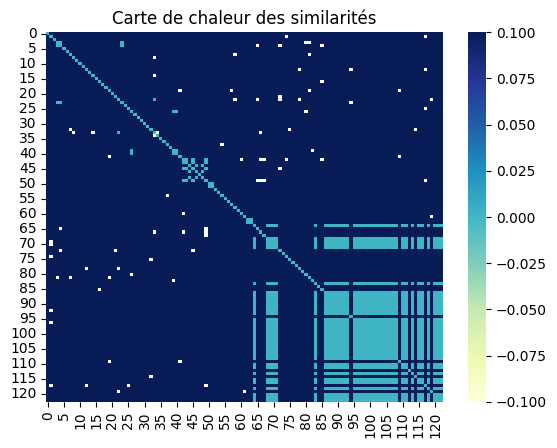

In [ ]:
import seaborn as sns

# Créer une carte de chaleur en utilisant les données de la matrice de similarité
sns.heatmap(distance_matrix, cmap='YlGnBu')
plt.title('Carte de chaleur des distances normalisées')
plt.show()


# Testing

In [ ]:
data_douala = pd.read_csv('Douala/CML_Douala/test.csv', sep=';', parse_dates=['datetime'])

In [ ]:
data_douala.dropna(inplace=True)
data_douala.head()

,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
14106,2019-01-24 22:35:00,45 A-B,172.22.208.16P4.1-172.22.208.9P8.1,1.26,15,13.0,13.0,13.0,-44.0,-43.0,-43.0,0.0,Lycee_NYALLA,0.612958,MPR_LOGBABA_1 - 10G_MPR_Ndogpassi_1,0.0517,1.0943
14107,2019-01-24 22:50:00,45 A-B,172.22.208.16P4.1-172.22.208.9P8.1,1.26,15,13.0,13.0,13.0,-44.0,-43.0,-43.0,0.0,Lycee_NYALLA,0.612958,MPR_LOGBABA_1 - 10G_MPR_Ndogpassi_1,0.0517,1.0943
14108,2019-01-24 23:05:00,45 A-B,172.22.208.16P4.1-172.22.208.9P8.1,1.26,15,13.0,13.0,13.0,-44.0,-43.0,-43.0,0.0,Lycee_NYALLA,0.612958,MPR_LOGBABA_1 - 10G_MPR_Ndogpassi_1,0.0517,1.0943
14109,2019-01-24 23:20:00,45 A-B,172.22.208.16P4.1-172.22.208.9P8.1,1.26,15,13.0,13.0,13.0,-44.0,-43.0,-43.0,0.0,Lycee_NYALLA,0.612958,MPR_LOGBABA_1 - 10G_MPR_Ndogpassi_1,0.0517,1.0943
14110,2019-01-24 23:35:00,45 A-B,172.22.208.16P4.1-172.22.208.9P8.1,1.26,15,13.0,13.0,13.0,-44.0,-43.0,-43.0,0.0,Lycee_NYALLA,0.612958,MPR_LOGBABA_1 - 10G_MPR_Ndogpassi_1,0.0517,1.0943


In [ ]:
metaValue = 1
card = []
for i in range(data_douala.shape[1]):
    card.append(len(data_douala.iloc[:, i].unique()))

# extraction of non Meta information
subset = np.array(card) > metaValue
df = data_douala.loc[:, subset]

# date identification
df.loc[:, 'datetime']=pd.to_datetime(df.loc[:,"datetime"], format="%Y-%m-%d %H:%M:%S")
df.set_index("datetime", inplace=True)
df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

#remove observations with NA information
df.dropna(inplace=True)

# Normalisation

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)


# Process the data to find the rain events (same as in your previous code)
X=df_scaled.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
y=df_scaled.Rgage

clustering =  ProposedApproach(X.values, 1200, 100, 4, 1)
clustering.fit()
clustering.cluster_outliers()
labels1 = clustering.labels

# Créer un nouveau DataFrame pour stocker les données des événements de pluie
rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

# Initialiser les variables pour stocker les données des événements de pluie
event = 0
amplitudes = []

# Parcourir les données des labels
for i in range(len(labels1)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels1[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean aux amplitudes de l'événement en cours
        amplitudes.append(df['TSL_mean'].iloc[i])
    else:
        # Si les amplitudes de l'événement en cours ne sont pas vides
        if len(amplitudes) > 0:
            # Vérifier si les labels suivants sont également 0
            next_labels_zero = True
            for j in range(i, min(i+10, len(labels1))):
                if labels1[j] != 0:
                    next_labels_zero = False
                    break
            # Si les labels suivants sont également 0
            if next_labels_zero:
                # Ajouter les données de l'événement en cours au DataFrame
                rain_events.loc[event] = [event, amplitudes]
                # Réinitialiser les variables pour le prochain événement
                event += 1
                amplitudes = []

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
all_events = pd.read_csv('rain_events_sep.csv')
all_events

,Event,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a14218,a14219,a14220,a14221,a14222,a14223,a14224,a14225,a14226,a14227
0,0,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.5,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8.6,8.3,7.7,8.1,7.7,7.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9.8,8.3,7.6,10.6,8.8,7.7,7.6,7.9,10.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7.2,8.2,7.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,96,13.0,13.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,97,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,98,13.2,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1464,99,13.0,13.0,13.0,13.4,13.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Créer un nouveau DataFrame avec des colonnes séparées pour chaque amplitude
rain_events_= pd.DataFrame(columns=['Event'] + [f'a{i+1}' for i in range(all_events.shape[1])])
# Iterate over the data from the non-rain events
for i, row in rain_events.iterrows():
    # Add the data for the event to the DataFrame
    rain_events_.loc[i, 'Event'] = row['Event']
    for j, amp in enumerate(row['Amplitudes']):
        rain_events_.loc[i, f'a{j+1}'] = amp

# Remplacer les valeurs manquantes par 0
rain_events_.fillna(0, inplace=True)
rain_events_.drop(['Event'], axis=1, inplace=True)
rain_events_



,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a14219,a14220,a14221,a14222,a14223,a14224,a14225,a14226,a14227,a14228
0,15.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,15.9,14.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,13.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,14.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,13.0,13.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
97,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
98,13.2,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99,13.0,13.0,13.0,13.4,13.0,13.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(all_events.values, labels)
predicted_labels = neigh.predict(rain_events_)

In [ ]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0,
       0, 6, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

# Testing for one event taken from the train set

### Classification of the events using knn

In [ ]:
data_train = pd.read_csv('Douala/CML_Douala/L1_172.22.206.16P4.4-172.22.206.30P3.1_35A-B.csv', sep=';', parse_dates=['datetime'])

In [ ]:
data_train.dropna(inplace=True)
data_train.head()

,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
3602,2018-07-20 12:35:00,35 A-B,172.22.206.16P4.4-172.22.206.30P3.1,2.82,14.5,6.0,6.3,6.5,-54.6,-54.0,-53.4,0.0,Meteo_IUT,2.030449,10G_MPR_MAKEPE-NODAL_2 - MPR_MAKEPE-MISSOKE,0.0473,1.1022
3603,2018-07-20 12:50:00,35 A-B,172.22.206.16P4.4-172.22.206.30P3.1,2.82,14.5,6.0,6.0,6.0,-54.6,-54.2,-53.8,0.0,Meteo_IUT,2.030449,10G_MPR_MAKEPE-NODAL_2 - MPR_MAKEPE-MISSOKE,0.0473,1.1022
3604,2018-07-20 13:05:00,35 A-B,172.22.206.16P4.4-172.22.206.30P3.1,2.82,14.5,6.0,6.0,6.0,-54.7,-54.3,-53.9,0.0,Meteo_IUT,2.030449,10G_MPR_MAKEPE-NODAL_2 - MPR_MAKEPE-MISSOKE,0.0473,1.1022
3605,2018-07-20 13:20:00,35 A-B,172.22.206.16P4.4-172.22.206.30P3.1,2.82,14.5,6.0,6.0,6.0,-54.7,-54.2,-53.7,0.0,Meteo_IUT,2.030449,10G_MPR_MAKEPE-NODAL_2 - MPR_MAKEPE-MISSOKE,0.0473,1.1022
3606,2018-07-20 13:35:00,35 A-B,172.22.206.16P4.4-172.22.206.30P3.1,2.82,14.5,6.0,6.0,6.0,-54.8,-54.3,-53.9,0.0,Meteo_IUT,2.030449,10G_MPR_MAKEPE-NODAL_2 - MPR_MAKEPE-MISSOKE,0.0473,1.1022


In [ ]:
metaValue = 1
card = []
for i in range(data_douala.shape[1]):
    card.append(len(data_douala.iloc[:, i].unique()))

# extraction of non Meta information
subset = np.array(card) > metaValue
df = data_train.loc[:, subset]

# date identification
df.loc[:, 'datetime']=pd.to_datetime(df.loc[:,"datetime"], format="%Y-%m-%d %H:%M:%S")
df.set_index("datetime", inplace=True)
df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

#remove observations with NA information
df.dropna(inplace=True)

# Normalisation

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)


# Process the data to find the rain events (same as in your previous code)
X=df_scaled.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
y=df_scaled.Rgage

clustering =  ProposedApproach(X.values, 1200, 100, 4, 1)
clustering.fit()
clustering.cluster_outliers()
labels1 = clustering.labels

# Créer un nouveau DataFrame pour stocker les données des événements de pluie
rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

# Initialiser les variables pour stocker les données des événements de pluie
event = 0
amplitudes = []

signal = []
# Parcourir les données des labels
for i in range(len(labels1)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels1[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean aux amplitudes de l'événement en cours
        amplitudes.append(df['TSL_mean'].iloc[i])
        signal.append(df['TSL_mean'].iloc[i])
    else:
        # Si les amplitudes de l'événement en cours ne sont pas vides
        if len(amplitudes) > 0:
            # Vérifier si les labels suivants sont également 0
            next_labels_zero = True
            for j in range(i, min(i+10, len(labels1))):
                if labels1[j] != 0:
                    next_labels_zero = False
                    break
            # Si les labels suivants sont également 0
            if next_labels_zero:
                # Ajouter les données de l'événement en cours au DataFrame
                rain_events.loc[event] = [event, amplitudes]
                # Réinitialiser les variables pour le prochain événement
                event += 1
                amplitudes = []

new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(all_events.values, labels)
predicted_labels = neigh.predict(rain_events_)

In [ ]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0,
       0, 6, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
all_events

,Event,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a14218,a14219,a14220,a14221,a14222,a14223,a14224,a14225,a14226,a14227
0,0,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.5,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8.6,8.3,7.7,8.1,7.7,7.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9.8,8.3,7.6,10.6,8.8,7.7,7.6,7.9,10.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7.2,8.2,7.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,96,13.0,13.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,97,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,98,13.2,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1464,99,13.0,13.0,13.0,13.4,13.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


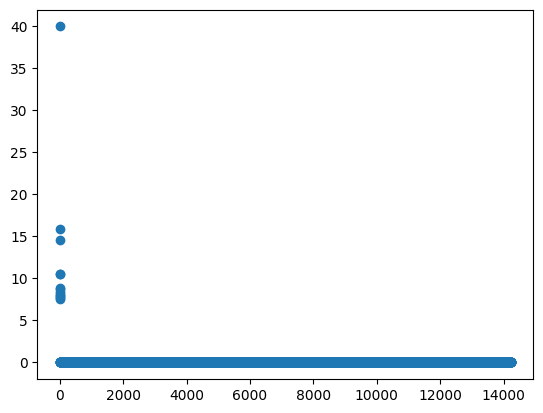

In [ ]:
plt.scatter(x=range(len(all_events.values[40])), y=all_events.values[40])

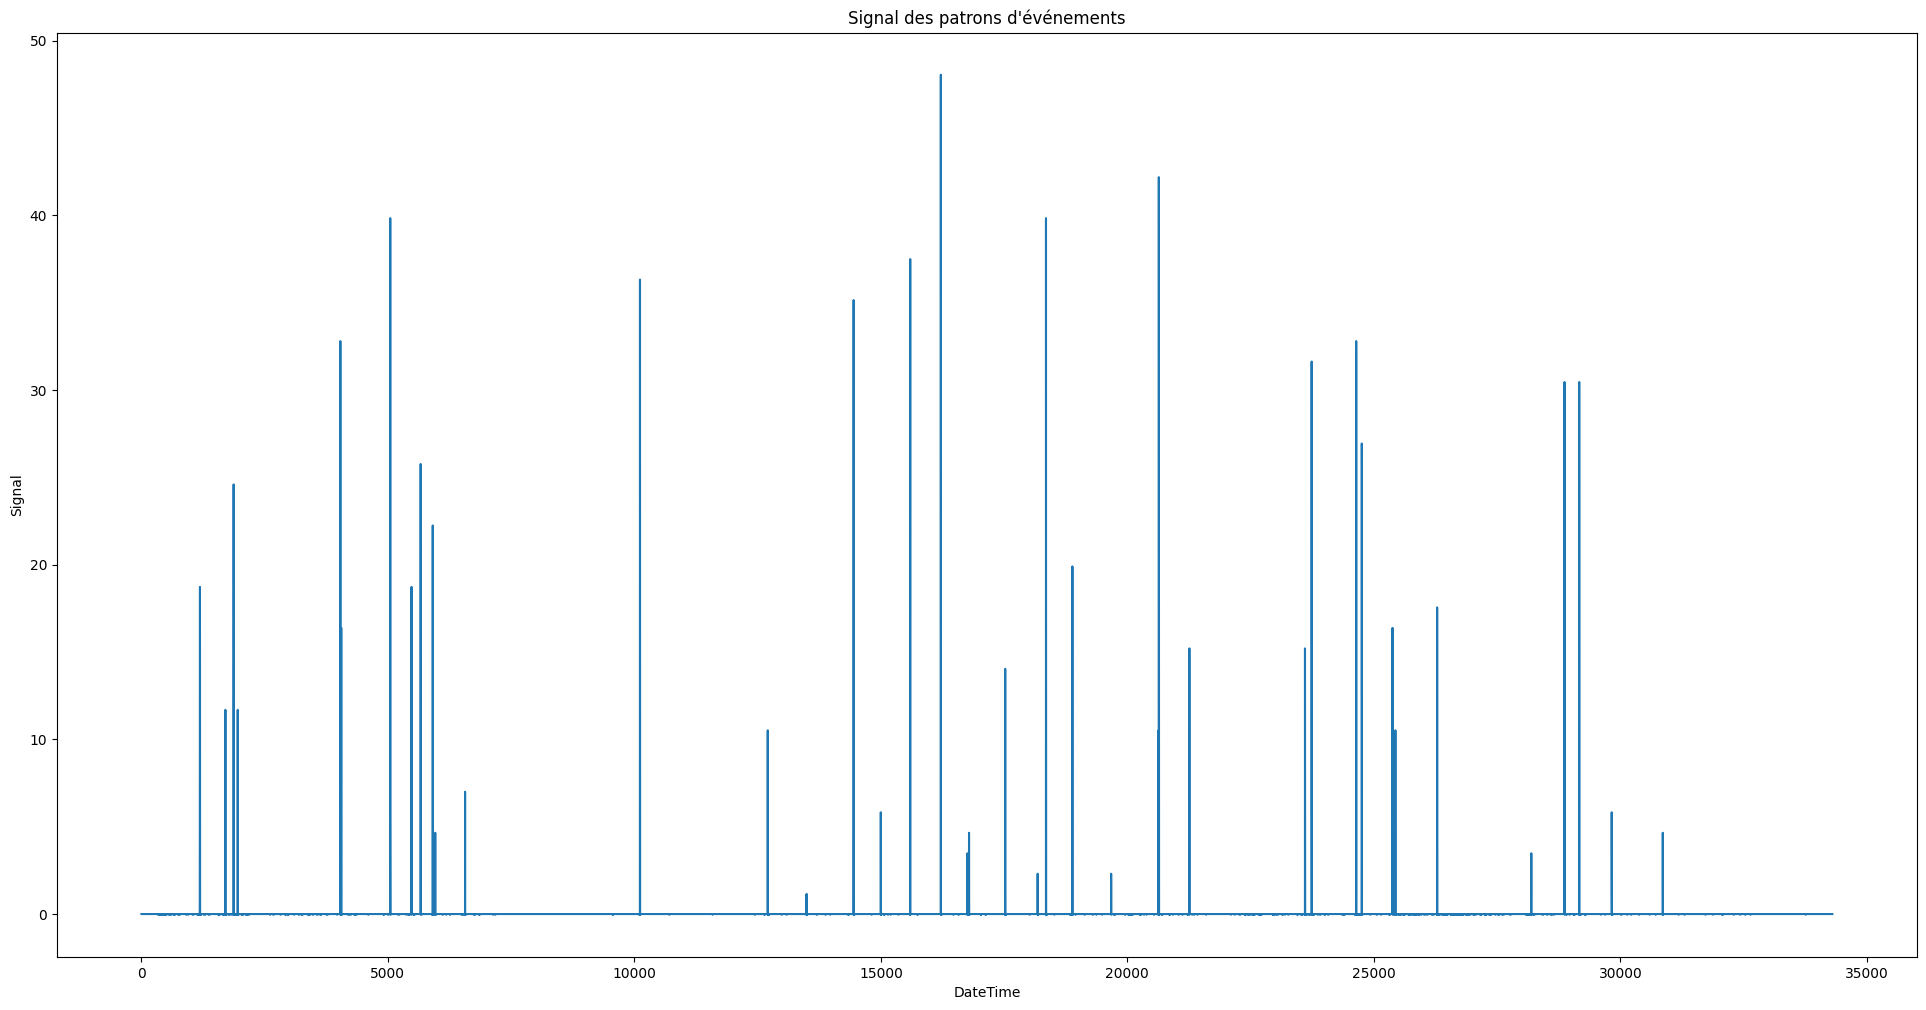

In [ ]:
plt.figure(figsize=(24, 12))
# Créer une liste pour stocker les données du signal
signal = []

# Parcourir les données des labels
for i in range(len(labels1)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels1[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean au signal
        signal.append(df_scaled['TSL_mean'].iloc[i])
    else:
        # Sinon, ajouter 0 au signal
        signal.append(0)

# Créer un graphique en utilisant les données du signal
plt.plot(signal)
plt.xlabel('DateTime')
plt.ylabel('Signal')
plt.title('Signal des patrons d\'événements')
plt.show()

